In [115]:
import pandas as pd
import numpy as  np

In [4]:
import matplotlib.pyplot as plt

In [5]:
movies_df = pd.read_csv('ml-1m/ml-1m/movies.dat',
                        delimiter='::',encoding='latin-1',engine= 'python', header=None,
                        names=['movie_id','movie_name', 'genre'])

In [6]:


users_df = pd.read_csv(f'ml-1m/ml-1m/users.dat',encoding='latin-1',
                       delimiter='::', engine='python', header=None,
                       names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])


In [7]:
ratings_df = pd.read_csv('ml-1m/ml-1m/ratings.dat',
                         delimiter='::', encoding='latin-1',engine='python', header=None,
                         names=['user_id', 'movie_id', 'rating', 'time'])

In [205]:
user_rating = pd.merge(users_df,ratings_df,on='user_id')

In [9]:
final_dataset = pd.merge(user_rating,movies_df,on='movie_id')

In [112]:
#first I am trying replacing nan with 0
user_item_matrix = user_rating.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

In [129]:
#next I am trying to replacing nan with mean
user_item_matrix_ = user_rating.pivot(index='user_id', columns='movie_id', values='rating').fillna(2.5)

In [125]:
#formula for cosine similarity  as norm of anything is  = square root of dot product with himself
def cosine_similarity(matrix):
    similarity = np.dot(matrix.T,matrix)
    similarity/= np.sqrt(np.outer(np.diag(similarity.T),np.diag(similarity)))
    return similarity


In [150]:
similarity_matrix = cosine_similarity(user_item_matrix_)

In [151]:
similarity_matrix

array([[1.        , 0.95331122, 0.95190488, ..., 0.95614549, 0.9556697 ,
        0.9482011 ],
       [0.95331122, 1.        , 0.98109349, ..., 0.98657701, 0.98640839,
        0.97705269],
       [0.95190488, 0.98109349, 1.        , ..., 0.9899897 , 0.98991776,
        0.98038907],
       ...,
       [0.95614549, 0.98657701, 0.9899897 , ..., 1.        , 0.99723653,
        0.98832633],
       [0.9556697 , 0.98640839, 0.98991776, ..., 0.99723653, 1.        ,
        0.98834141],
       [0.9482011 , 0.97705269, 0.98038907, ..., 0.98832633, 0.98834141,
        1.        ]])

In [132]:
#trying to calculate cosine similarity excluding non-common users , took 300 minutes so not very time efficient
def calculate_movie_similarity(movie_id1, movie_id2):
    ratings1 = user_item_matrix[movie_id1]
    ratings2 = user_item_matrix[movie_id2]

    common_users = ratings1[ratings1 != 0].index.intersection(ratings2[ratings2 != 0].index)

    if len(common_users) == 0:
        return 0.0  

    vector1 = ratings1.loc[common_users].values
    vector2 = ratings2.loc[common_users].values

    similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    return similarity


num_movies = user_item_matrix.shape[1]
movie_ids = user_item_matrix.columns
similarity_matrix = np.zeros((num_movies, num_movies))

for i in range(num_movies):
    for j in range(i+1, num_movies):
        movie_id1, movie_id2 = movie_ids[i], movie_ids[j]
        similarity = calculate_movie_similarity(movie_id1, movie_id2)
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity 


KeyboardInterrupt: 

In [153]:
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.columns, columns=user_item_matrix.columns)

In [49]:
#function to predict rating of a movie
def predict_movie_rating(user_id,movie_id,similarity_matrix,user_rating):
    indices = user_rating.columns[user_rating.loc[user_id] != 0]
    similarity = similarity_matrix.loc[movie_id,indices]
    
    ratings = user_rating.loc[user_id,similarity.index]
    weighted = np.dot(similarity,ratings)
    divide = abs(similarity).sum()
    
    ret = weighted/divide +user_avg_ratings[user_id] 
    return ret

In [158]:
predict_movie_rating(2,1193,similarity_df,user_item_matrix)-user_avg_ratings[2]

3.7117090396681154

In [137]:
#getting average of rattings provided by a particular user
user_avg_ratings = user_rating.groupby('user_id')['rating'].mean()

In [258]:
df = pd.merge(user_rating, user_avg_ratings, left_on='user_id', right_index=True, suffixes=('', '_avg'))


In [259]:
#calculating normalised ratings
df['normal'] = df['rating']-df['rating_avg']

In [140]:
#a normalised rating matrix that can be used with any kind of similarity
normal_item_matrix = df.pivot(index='user_id', columns='movie_id', values='normal').fillna(0)

In [159]:
#normalised cosine similarity aka persons correlation coefficient
cor_sim = cosine_similarity(normal_item_matrix)

In [63]:
#filling diagonal values as 0 so that I don't count same movies in predicting ratings
np.fill_diagonal(cor_sim,0)

In [160]:
#converting matrix into datafram for better usage
cor_sim_df = pd.DataFrame(cor_sim, index=normal_item_matrix.columns, columns=normal_item_matrix.columns)

In [164]:
#that will be how it's calculating adding the mean to the predicted value
predict_movie_rating(2,1193,cor_sim_df,normal_item_matrix)

4.178648792111135

In [165]:
user_movies = user_rating.groupby('user_id')['movie_id'].count()


In [166]:
user_movies.replace(0, 3883, inplace=True)

In [167]:
#counting weights based on total number of movies a user has watched
user_weights = np.sqrt(np.log(3883/user_movies))

In [260]:
df_  = pd.merge(df, user_weights, left_on='user_id', right_index=True, suffixes=('', 'weights'))


In [169]:
df_['weighted'] = df_['normal']*df_['movie_idweights']

In [170]:
#weighted matrix to calculate weighted correlation similarity
weighted_item_matrix = df_.pivot(index='user_id',columns='movie_id',values='weighted').fillna(0)

In [171]:
#weighted correlation similarity
w_cor = cosine_similarity(weighted_item_matrix)

In [172]:
np.fill_diagonal(w_cor,0)

In [173]:
#converting matrix into dataframe
w_cor_df = pd.DataFrame(w_cor,index=weighted_item_matrix.columns,columns=weighted_item_matrix.columns)

In [176]:
predict_movie_rating(2,1193,w_cor_df,normal_item_matrix)

4.150675266864334

In [177]:
#this is so that I can retrieve movie names
i_movie = movies_df.set_index('movie_id')

In [185]:
#functions to recommend movies
def movie_recommender(user_id,similarity):
    indices = user_item_matrix.columns[user_item_matrix.loc[user_id] == 0]
    ind = pd.DataFrame(indices)
    data = []
    for i in indices:
        data.append(predict_movie_rating(user_id,i,similarity,normal_item_matrix))
    ind['ratings'] = data
    ind['ratings'] = ind['ratings']
    top = ind.sort_values(by='ratings', ascending=False)[1:10]
    movies = i_movie.loc[top['movie_id']]
    movies = pd.merge(top,movies,on='movie_id')

    

    return movies



In [186]:
movie_recommender(1,w_cor_df)

C:\Users\Akshansh\AppData\Local\Temp\ipykernel_11872\725082997.py:10: RuntimeWarning: invalid value encountered in scalar divide
  ret = weighted/divide +user_avg_ratings[user_id]


,movie_id,ratings,movie_name,genre
0,1915,5.000000,Voyage to the Beginning of the World (1997),Drama
1,3172,4.799056,Ulysses (Ulisse) (1954),Adventure
2,3084,4.742929,Home Page (1999),Documentary
3,690,4.723361,"Promise, The (Versprechen, Das) (1994)",Romance
4,3890,4.716737,Back Stage (2000),Documentary
5,545,4.607613,Harlem (1993),Drama
6,1709,4.607206,Legal Deceit (1997),Thriller
7,3290,4.607206,Soft Toilet Seats (1999),Comedy
8,127,4.603408,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama


In [81]:
max = user_rating['time'].max()

In [204]:
user_rating['time'] = pd.to_numeric(user_rating['time'])

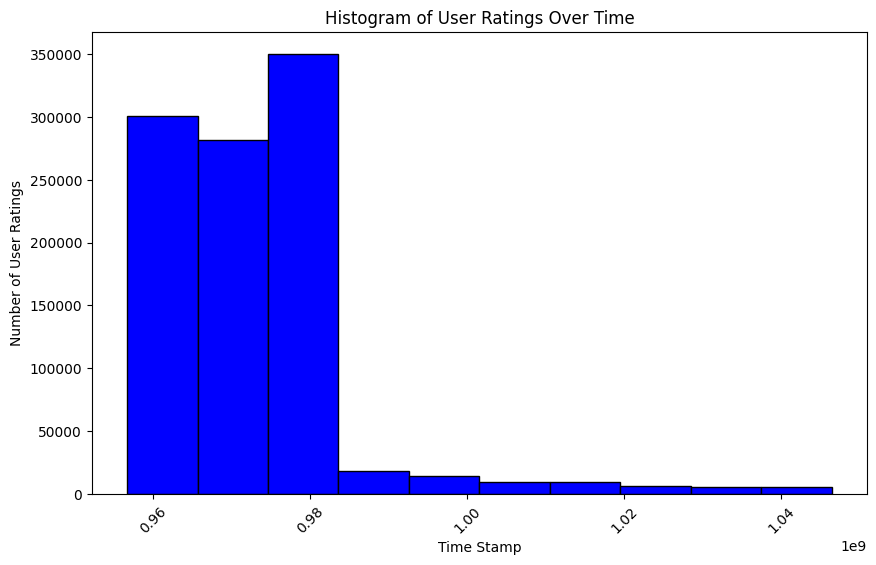

In [206]:


# I need to figure out the correct decay factor that makes use of all the ratings yet decaying them
plt.figure(figsize=(10, 6))
plt.hist(user_rating['time'], bins=10, color='blue', edgecolor='black')
plt.xlabel('Time Stamp')
plt.ylabel('Number of User Ratings')
plt.title('Histogram of User Ratings Over Time')
plt.xticks(rotation=45)
plt.show()

In [84]:
#finally I got the weight after playing around with the decay factor
user_rating['decay_weight'] = (1-0.0000083)**(max -user_rating['time'])


In [105]:
#by using this value most of the weights are non-zero and hence it's usable
user_rating['decay_weight'].sort_values(ascending=False)

825603      1.000000e+00
825724      9.996515e-01
825731      9.996515e-01
825438      9.987806e-01
825793      9.979106e-01
               ...      
996604     4.940656e-324
996601     4.940656e-324
996600     4.940656e-324
996599     4.940656e-324
1000208    4.940656e-324
Name: decay_weight, Length: 1000209, dtype: float64

In [86]:
df['decay_weight'] = user_rating['decay_weight']

In [87]:
df['decayed']= df['normal']*df['decay_weight']

In [88]:
#decayed rating matrix
decay_item_matrix = df.pivot(index='user_id',columns='movie_id',values='decayed').fillna(0)

In [ ]:
decay_item_matrix

In [91]:
#decayed correlation similarity
decay_sim = cosine_similarity(decay_item_matrix)

C:\Users\Akshansh\AppData\Local\Temp\ipykernel_11872\1370891535.py:2: RuntimeWarning: divide by zero encountered in divide
  similarity = np.dot(matrix.T,matrix)/(np.linalg.norm(matrix.T,axis=1)[:,None]*np.linalg.norm(matrix,axis=0))
C:\Users\Akshansh\AppData\Local\Temp\ipykernel_11872\1370891535.py:2: RuntimeWarning: invalid value encountered in divide
  similarity = np.dot(matrix.T,matrix)/(np.linalg.norm(matrix.T,axis=1)[:,None]*np.linalg.norm(matrix,axis=0))


In [92]:
decay_sim_df = pd.DataFrame(decay_sim,index=decay_item_matrix.columns,columns=decay_item_matrix.columns)

In [93]:
predict_movie_rating(2,1193,decay_sim_df,normal_item_matrix)

4.999999047319135

In [187]:
#recommending movies to a user based on correlation similarity
movie_recommender(3000,cor_sim_df)

C:\Users\Akshansh\AppData\Local\Temp\ipykernel_11872\725082997.py:10: RuntimeWarning: invalid value encountered in scalar divide
  ret = weighted/divide +user_avg_ratings[user_id]


,movie_id,ratings,movie_name,genre
0,133,4.337192,Nueba Yol (1995),Comedy|Drama
1,2258,4.149292,Master Ninja I (1984),Action
2,1729,4.137902,Jackie Brown (1997),Crime|Drama
3,176,4.117010,Living in Oblivion (1995),Comedy
4,2438,4.111907,Outside Ozona (1998),Drama|Thriller
5,1412,4.111747,Some Mother's Son (1996),Drama
6,994,4.084650,Big Night (1996),Drama
7,3543,4.082492,Diner (1982),Comedy|Drama
8,1296,4.062059,"Room with a View, A (1986)",Drama|Romance


In [190]:
#recommending movies based on weghted similerity
movie_recommender(3000,w_cor_df)

C:\Users\Akshansh\AppData\Local\Temp\ipykernel_11872\725082997.py:10: RuntimeWarning: invalid value encountered in scalar divide
  ret = weighted/divide +user_avg_ratings[user_id]


,movie_id,ratings,movie_name,genre
0,2258,4.490577,Master Ninja I (1984),Action
1,133,4.344517,Nueba Yol (1995),Comedy|Drama
2,176,4.114828,Living in Oblivion (1995),Comedy
3,2438,4.110680,Outside Ozona (1998),Drama|Thriller
4,1729,4.105975,Jackie Brown (1997),Crime|Drama
5,3543,4.081321,Diner (1982),Comedy|Drama
6,994,4.068390,Big Night (1996),Drama
7,3647,4.062955,Running Free (2000),Drama
8,1296,4.059540,"Room with a View, A (1986)",Drama|Romance


In [189]:
#recommending movies based on cosine similarity
movie_recommender(3000,similarity_df)

,movie_id,ratings,movie_name,genre
0,50,3.261896,"Usual Suspects, The (1995)",Crime|Thriller
1,608,3.261825,Fargo (1996),Crime|Drama|Thriller
2,1136,3.261569,Monty Python and the Holy Grail (1974),Comedy
3,1617,3.261292,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
4,318,3.261248,"Shawshank Redemption, The (1994)",Drama
5,1394,3.261199,Raising Arizona (1987),Comedy
6,858,3.261178,"Godfather, The (1972)",Action|Crime|Drama
7,1089,3.260976,Reservoir Dogs (1992),Crime|Thriller
8,1213,3.260950,GoodFellas (1990),Crime|Drama


In [192]:
#here I am figuring out why I am not getting recommended very old movies and if I can do anything with time of the movie released
import re
movies_df['year'] = movies_df['movie_name'].apply(lambda movie_name: re.search('\((\d*)\)', movie_name).groups(1)[0])

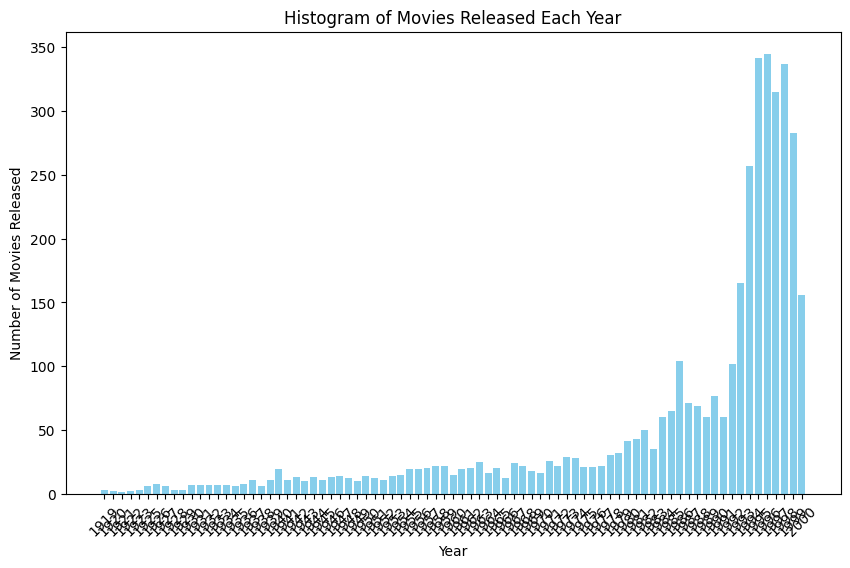

In [195]:
movies_per_year = movies_df['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(movies_per_year.index, movies_per_year.values, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.title('Histogram of Movies Released Each Year')
plt.xticks(rotation=45)
plt.show()

Well seems like I can add some weights to the older movies but I can do this in future , as I have not yet figured out what weights I should add should it be exponential decay or simply frequency of the movies/total movies.

In [201]:
movies_df['genre'] = movies_df['genre'].apply(lambda x: x.split('|'))
movies_df_exploded = movies_df.explode('genre')


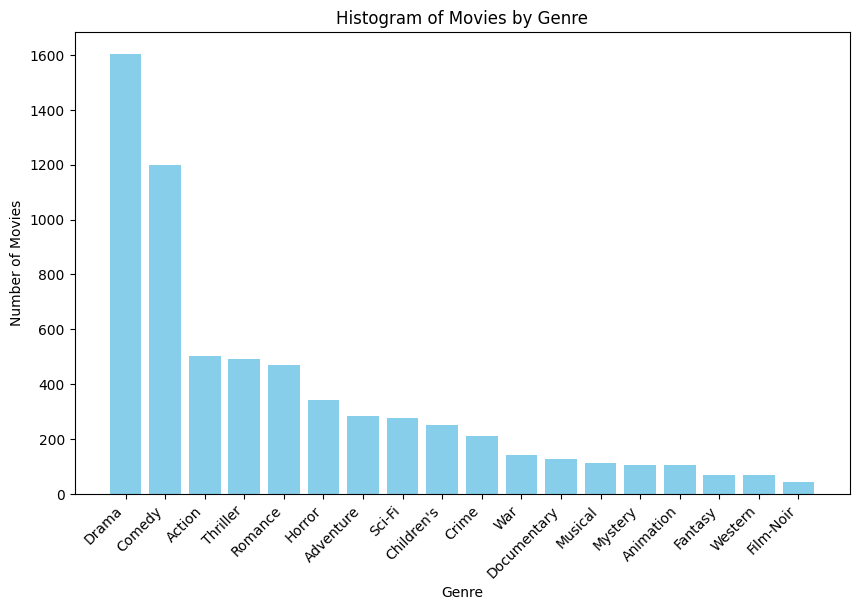

In [232]:
genre_counts = movies_df_exploded['genre'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values, color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Histogram of Movies by Genre')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
#Here I am just trying out if I can do anything of genres it's a failed attempt as it recommends movies of a particular genre only to the users

In [207]:
from sklearn.preprocessing import MultiLabelBinarizer

In [210]:
mlb = MultiLabelBinarizer()
genres_binary = pd.DataFrame(mlb.fit_transform(movies_df['genre']), columns=mlb.classes_, index=movies_df['movie_id'])

In [213]:
genres_binary = genres_binary.astype('float64')

In [215]:
genre_similarity = cosine_similarity(genres_binary.T)

In [220]:
genre_similarity_df = pd.DataFrame(genre_similarity,index=genres_binary.index, columns=genres_binary.index)

In [219]:
np.fill_diagonal(genre_similarity,0)

In [226]:
#well it's not very good , need to figure out any way to add weights based on genres to the other similarity maybe it should depend on total movies in a particular genre
movie_recommender(1,genre_similarity_df)

C:\Users\Akshansh\AppData\Local\Temp\ipykernel_11872\725082997.py:10: RuntimeWarning: invalid value encountered in scalar divide
  ret = weighted/divide +user_avg_ratings[user_id]


,movie_id,ratings,movie_name,genre
0,760,5.0,Stalingrad (1993),War
1,3367,5.0,"Devil's Brigade, The (1968)",War
2,632,5.0,Land and Freedom (Tierra y libertad) (1995),War
3,1450,5.0,Prisoner of the Mountains (Kavkazsky Plennik) ...,War
4,2669,5.0,Pork Chop Hill (1959),War
5,3339,5.0,Cross of Iron (1977),War
6,3670,5.0,"Story of G.I. Joe, The (1945)",War
7,1927,5.0,All Quiet on the Western Front (1930),War
8,2670,5.0,"Run Silent, Run Deep (1958)",War


Hence now I am deciding just like I have added weights based on total movies a user has rated , I can add weights on basis of total movies in a particular genre , I am taking log of [total movies/total movie in that genre ] this will make sure a movie that is of genre having very less users get's more weight.

In [235]:
genre_counts = movies_df_exploded['genre'].value_counts()


In [241]:
genre_weights = np.sqrt(np.log(3883/genre_counts))

In [246]:
genredata = pd.merge(movies_df_exploded,genre_weights,on='genre')

In [254]:
#calculating weights associated with each movie here i am considering maximum of the all genres
movieweight = genredata.groupby('movie_id')['count'].max()

In [262]:
weightdata = pd.merge(df,movieweight,on='movie_id')

In [267]:
weightdata['weightedtrix'] = weightdata['normal']*weightdata['count']

In [270]:
genre_weighted_matrix = pd.pivot(weightdata,index='user_id',columns='movie_id',values='count').fillna(0)

In [274]:
genre_weited_similarity = cosine_similarity(genre_weighted_matrix)

In [281]:
#now I have a similarity matrix where I have multiplied genre weights
genre_Weight_sim = pd.DataFrame(genre_weited_similarity,index=genre_weighted_matrix.columns,columns=genre_weighted_matrix.columns)

In [286]:
#recommending movies based on genre weights and cosine similarity
movie_recommender(800,genre_Weight_sim)

,movie_id,ratings,movie_name,genre
0,989,4.843422,Schlafes Bruder (Brother of Sleep) (1995),Drama
1,624,4.504215,Condition Red (1995),Action|Drama|Thriller
2,3382,4.443915,Song of Freedom (1936),Drama
3,3323,4.443915,Chain of Fools (2000),Comedy|Crime
4,127,4.443915,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama
5,3779,4.374767,Project Moon Base (1953),Sci-Fi
6,3890,4.288253,Back Stage (2000),Documentary
7,655,4.185079,Mutters Courage (1995),Comedy
8,1709,4.157411,Legal Deceit (1997),Thriller
